## Lab 6:  Regression
#### CS 3300
#### Draven Schilling
#### 11/1/19
First created in 1949, Motor Trend US is an automobile magazine by The Motor Trend Group out of Los Angeles California. The magazine provides information such as road tests, vehicle comparisons, automobile trends and some unique featured cars. It's popularity has increased over the years and as of 2019 it has over a million concurrent readers worldwide. 

In this notebook we will be looking at a provided chart from a 1974 issue of Motor Trend which contains fuel efficiency along with 10 other aspects of automobile design and performance for 32 different cars from 1973-1974. The data contains 32 different cars and 10 categories plus the vehicle name. The features are as follows:

•	mpg -- miles per gallon
•	cyl -- numbers of cylinders
•	disp -- displacement (cu. in.)
•	hp -- gross horsepower
•	drat -- rear axle ratio
•	wt -- weight (in 1000s of lbs)
•	qsec -- 1/4 mile time
•	vs -- Engine Shape (0 = V-shaped, 1 = straight) 
•	am -- transmission (0 = automatic, 1 = manual)
•	gear -- number of forward gears
•	carb -- number of carburetors

In this notebook we will be analyzing the fuel efficiency of these cars as miles per gallon and determine which features are most impactful to a car's fuel efficiency. First, we will be doing some exploratory data analysis then using supervised machine learning algorithms to determine the predictive power for each feature and finally create some models using the features that are most powerful predictors.


In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import seaborn as sns

from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler

In [2]:
cars_df = pd.read_csv("mtcars.csv")
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 12 columns):
Unnamed: 0    32 non-null object
mpg           32 non-null float64
cyl           32 non-null int64
disp          32 non-null float64
hp            32 non-null int64
drat          32 non-null float64
wt            32 non-null float64
qsec          32 non-null float64
vs            32 non-null int64
am            32 non-null int64
gear          32 non-null int64
carb          32 non-null int64
dtypes: float64(5), int64(6), object(1)
memory usage: 3.1+ KB


### 1. Initial Hypotheses
The first goal is to identify which variables are most closely correlated with miles per gallon.
Based on my initial inspection I would believe metrics which have a strong impact on the amount of fuel used directly correlate with the power input of the automobile. In my opinion this would include number of cylinders, horsepower, and rear axle ratio (drat) to be the most strongly corelated with miles per gallon. Metrics such as mile time (qsec), engine shape (vs), and transmission type (am) I believe impact the amount of fuel used the least so I hypothesize these metrics will be the least correlated. Other features may correlate slightly but not strongly.

### 2. Cleaning the Data
Next, it will be useful to clean the data such that the column headers and types make sense and that missing values are dealt with. Fortunately there are no missing values so we don't have to impute or remove rows but I think it would be valuable to make the following changes.
Rename the Unnamed column to car_name to provide a more descriptive name. Next make both vs and am categorical because they can only be 1 of two bins. It may also be wise to make number of cylinders, number of forward gears, and number of carburetors all categorical.

In [3]:
def convertVs(val):
    return "V-shaped" if val == 0 else "straight"


def convertAm(val):
    return "automatic" if val == 0 else "manual"
        

cars_df['vs'] = cars_df["vs"].map(lambda s: convertVs(s))
cars_df['am'] = cars_df["am"].map(lambda s: convertAm(s))
cars_df.rename(columns={"Unnamed: 0": "car_name"}, inplace = True)
cars_df.cyl = cars_df.cyl.astype("category")
cars_df.gear = cars_df.gear.astype("category")
cars_df.carb = cars_df.carb.astype("category")
cars_df.vs = cars_df.vs.astype("category")
cars_df.am = cars_df.am.astype("category")
cars_df.head()

,car_name,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,V-shaped,manual,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,V-shaped,manual,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,straight,manual,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,straight,automatic,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,V-shaped,automatic,3,2


In [4]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 12 columns):
car_name    32 non-null object
mpg         32 non-null float64
cyl         32 non-null category
disp        32 non-null float64
hp          32 non-null int64
drat        32 non-null float64
wt          32 non-null float64
qsec        32 non-null float64
vs          32 non-null category
am          32 non-null category
gear        32 non-null category
carb        32 non-null category
dtypes: category(5), float64(5), int64(1), object(1)
memory usage: 2.6+ KB


### 3. Characterization of each variable 
Next, it may be useful to get a better idea of each variable by making a histogram of each. This will give us a distribution and range for each which we can then potentially use to better predict relations.

Number of cylinders


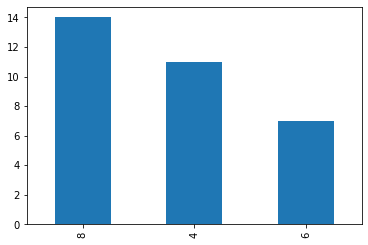

In [5]:
cars_df['cyl'].value_counts().plot.bar()
print("Number of cylinders")

Displacement (cu.in.):
min: 71.1 max: 472.0


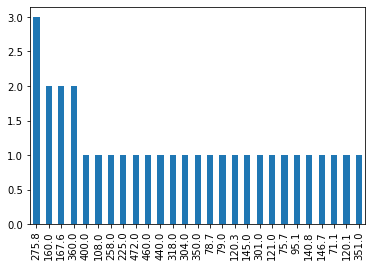

In [6]:
cars_df['disp'].value_counts().plot.bar()
print("Displacement (cu.in.):")
print("min: " + cars_df['disp'].min().astype(str) + " max: " + cars_df['disp'].max().astype(str))

gross horsepower:
min: 52 max: 335


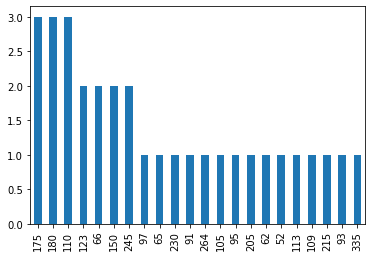

In [7]:
cars_df['hp'].value_counts().plot.bar()
print("gross horsepower:")
print("min: " + cars_df['hp'].min().astype(str) + " max: " + cars_df['hp'].max().astype(str))

rear axel ratio:
min: 2.76 max: 4.93


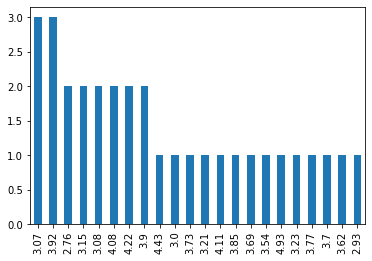

In [8]:
cars_df['drat'].value_counts().plot.bar()
print("rear axel ratio:")
print("min: " + cars_df['drat'].min().astype(str) + " max: " + cars_df['drat'].max().astype(str))

weight (in 1000's of lbs):
min: 1.5130000000000001 max: 5.4239999999999995


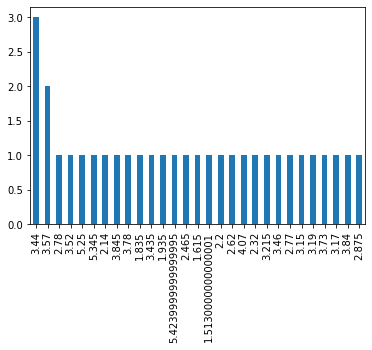

In [9]:
cars_df['wt'].value_counts().plot.bar()
print("weight (in 1000's of lbs):")
print("min: " + cars_df['wt'].min().astype(str) + " max: " + cars_df['wt'].max().astype(str))

1/4 mile time:
min: 14.5 max: 22.9


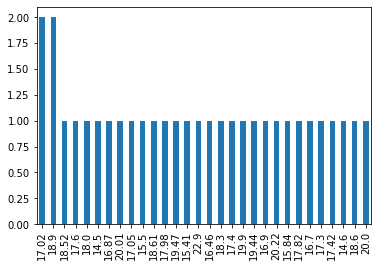

In [10]:
cars_df['qsec'].value_counts().plot.bar()
print("1/4 mile time:")
print("min: " + cars_df['qsec'].min().astype(str) + " max: " + cars_df['qsec'].max().astype(str))

Engine Shape


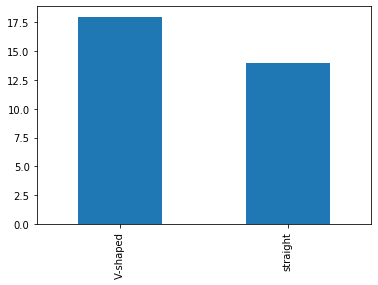

In [11]:
cars_df['vs'].value_counts().plot.bar()
print("Engine Shape")

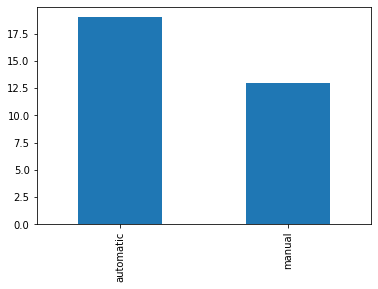

In [12]:
cars_df['am'].value_counts().plot.bar()

Number of forward gears:


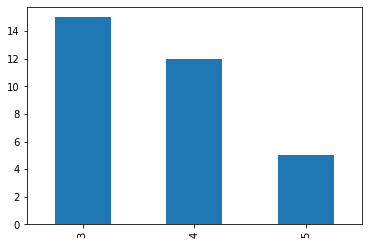

In [13]:
cars_df['gear'].value_counts().plot.bar()
print("Number of forward gears:")

Number of carburetors:


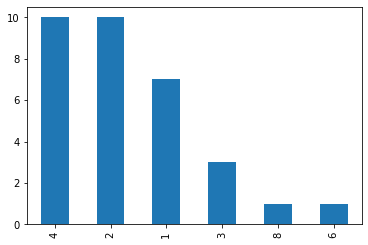

In [14]:
cars_df['carb'].value_counts().plot.bar()
print("Number of carburetors:")

From this inspection we can tell only number of cylinders, engine shape, transmission, number of forward gears, and number of carburetors all have well defined "bins" whereas the other categories seem to be mostly independent based on the car.
We can also tell that displacement and horsepower have a very large range whereas real axel ratio, weight, and 1/4 mile time are all more closely clumped within a smaller range.

### 4. Exploring Relationships between variables and mpg
Next, we put our hypothesizes to the test. We will attempt to plot each variable against mpg and see if there is any correlation and if our hypothesis was correct or not.

First, we will start with number of cylinders.

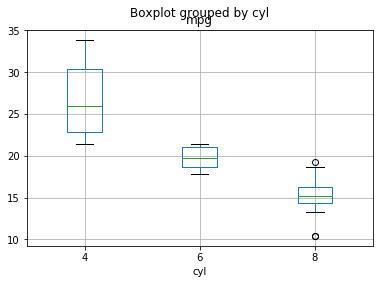

In [15]:
cars_df.boxplot(by="cyl", column="mpg")

For number of cylinders it seems clear there is a strong correlation such that as cylinders decrease, mpg also decreases. My initial hypothesis seems to so far be accurate about some of the influencers for what impacts mpg.

Next we will look at displacement.

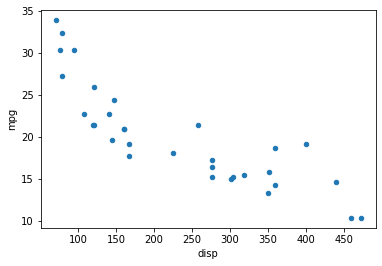

In [16]:
cars_df.plot(x='disp', y='mpg', kind='scatter')

For displacement, mpg trends downward as displacement increases in a more exponential relationship where it starts off with slight changes in displacement at the lower end (say 100-200 cu. in) impacting the mpg strongly but any further change impacts much less. Overall, I would still suggest this data is correlated with mpg, just maybe not as strongly as the number of cylinders was. 

Next, let’s look at horsepower.

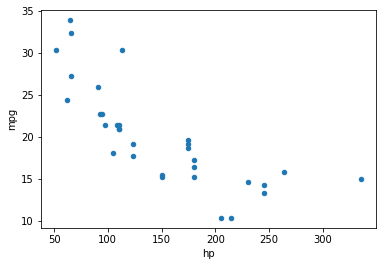

In [17]:
cars_df.plot(x='hp', y='mpg', kind='scatter')

Horsepower seems to trend similarly as displacement does such that changing from 100-200 hp has a significant impact on decreasing mpg whereas anything after 200hp does not seem to have much further of an impact.  Based on this observation and the general spread of the data, I would suggest horsepower has a similar, maybe slightly worse correlation then displacement. My initial hypothesis suggested there would be a greater correlation between horsepower and mpg then what I believe is present so at this rate it may start leaning towards incorrect.

Next, let’s look at rear axle ratio.

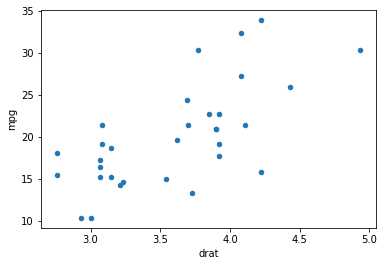

In [18]:
cars_df.plot(x='drat', y='mpg', kind='scatter')

For rear axle ratio there does seem to be a general linear trend towards larger ratios having better mpg but the spread is much larger than any of the previous variables we analyzed. Given this fact, I would suggest this correlation to be the lowest we have looked at so far. My initial hypothesis suggested a strong correlation because I thought having a higher ratio would make you more efficient, but it seems like does not have as great of an effect as I initially thought.

Next, lets look at a cars weight in relation to mpg.

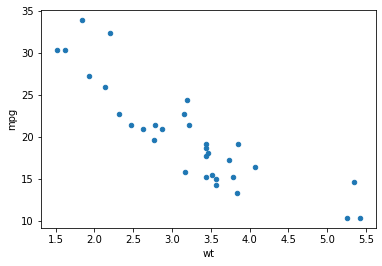

In [19]:
cars_df.plot(x='wt', y='mpg', kind='scatter')

Weight seems to be correlated similarly as displacement and horsepower except that it may be a bit more linear and therefore better according to the Pearson correlation coefficient.

Next, let’s look at 1/4 mile time.

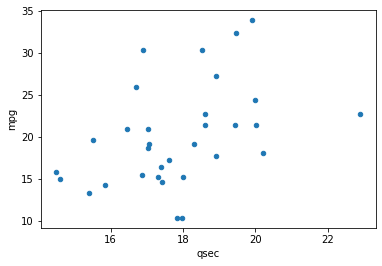

In [20]:
cars_df.plot(x='qsec', y='mpg', kind='scatter')

For 1/4-mile time, the spread seems to be too large to conclude any correlation from the data. My hypothesis also supported this idea because I hypothesized mile time would not be related to power metrics such as horsepower / axel ratio and therefore would not be directly related to mpg.

Next let’s look at engine shape.

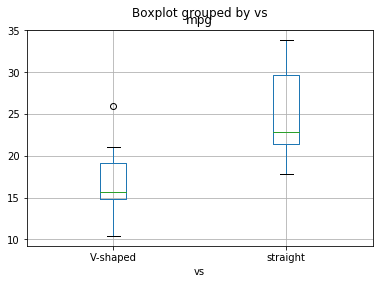

In [21]:
cars_df.boxplot(by="vs", column="mpg")

Initially I thought engine shape would have little to no impact on mpg because I wasn't sure how the science behind the different models could make that much of a difference. The data on the other hand, is surprising because there is clearly separation between the two with their medians being almost 5 mpg apart. I am still not sure why there could be this much of a difference the data clearly shows a correlation between engine shape and mpg.

Next let’s look at transmission type.

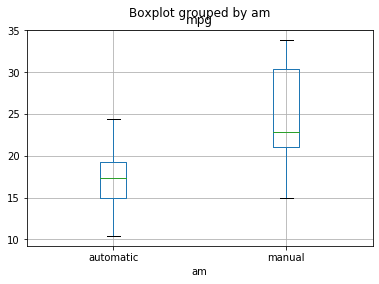

In [22]:
cars_df.boxplot(by="am", column="mpg")

Again, I am surprised to notice a separation between manual and automatic transmissions. Though the medians are still about 5 mpg apart, I would say the spreads of each are much closer together then engine shape; therefore, I would conclude still having a correlation between the two except the correlation being smaller than engine shape. I am also still curious here as to why there would be a difference between mpg and transmission type. Maybe humans are still more efficient at when to change gears or perhaps the simplicity of manual transmissions make them more efficient then automatic. Regardless, an interesting observation.

Down to the last two variables, let’s look at how the number of gears affect mpg.

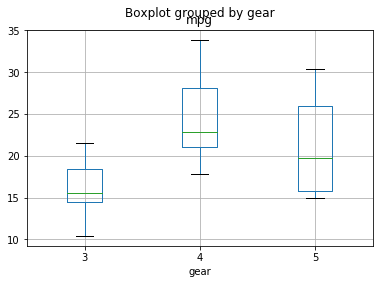

In [23]:
cars_df.boxplot(by="gear", column="mpg")

The spread of number of gears is interesting such that is looks similar to a bell curve. the median of 3 is less than 4, and 4 is greater than 5. The data clearly suggests no correlation but instead maybe an underlying association. My guess is that maybe 4 gears is optimal with 3 not being not efficient enough and 5 being unnecessary. An interesting observation but one that's likely not useful for linear regression which predicts mpg.

Finally let’s look at how the number of carburetors affect mpg.

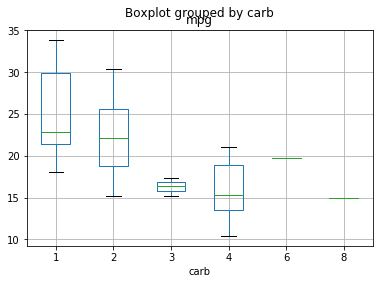

In [24]:
cars_df.boxplot(by="carb", column="mpg")

This one is interesting because the difference between 1 and 2 carburetors is not very different as is between 3 and 4 carburetors. but the difference between 1 and 2 versus 3 and 4 is statistically significant (with only 1 point of 6 carburetors being an outlier). Based on this observation I would suggest a correlation but maybe not a strong one since the only significant drop is between 2 and 3 carburetors.

Overall, after looking at each of the variables and predicting how well they correlate with mpg, we can finally organize them into a ordered list based on how well I feel they correlate with mpg.

1. Number of cylinders
2. Displacement
3. Weight
4. Engine shape
5. horsepower
6. Transmission
7. Number of carburetors
8. Rear axle ratio
9. 1/4 mile time
10. Number of gears

### Create Regression Models
Now we want to confirm our observations by creating a regression model using the predictive features of the data.
First, we must separate out our categorical variables and create dummy variables using 1 hot encoding for them. After that we can insert them back into our data frame and create a split (test/train) on our model (75% - 25%).

In [25]:
predictive_numerical_columns = ['disp', 'wt', 'hp']
predictive_categorical_columns = ['cyl', 'vs', 'am', 'carb']
predictive_all_columns = predictive_numerical_columns + predictive_categorical_columns
# add remaining columns to column list
all_columns = predictive_all_columns + ['drat', 'qsec', 'gear']

categorical_columns = predictive_categorical_columns + ['gear']
dummy_columns = {}
for col_name in categorical_columns:
    dummies = pd.get_dummies(cars_df[col_name], prefix=col_name)
    dummy_columns[col_name] = dummies.columns.values
    cars_df = cars_df.merge(dummies, left_index=True, right_index=True)
    cars_df = cars_df.drop(columns=col_name)



df_train, df_test = train_test_split(cars_df)
print(cars_df.shape[0], df_train.shape[0], df_test.shape[0])
print(dummy_columns)

32 24 8
{'cyl': array(['cyl_4', 'cyl_6', 'cyl_8'], dtype=object), 'vs': array(['vs_V-shaped', 'vs_straight'], dtype=object), 'am': array(['am_automatic', 'am_manual'], dtype=object), 'carb': array(['carb_1', 'carb_2', 'carb_3', 'carb_4', 'carb_6', 'carb_8'],
      dtype=object), 'gear': array(['gear_3', 'gear_4', 'gear_5'], dtype=object)}


#### Null Model
After splitting the testing and training data next we will work to create our null model using the intercept as a baseline to compare our future predictive models against. 

In [26]:
X_train = df_train[["disp"]].astype("float64").values
X_test = df_test[["disp"]].astype("float64").values
y_train = df_train["mpg"].values
y_test = df_test["mpg"].values

zeros_train = np.zeros(X_train.shape)
zeros_test = np.zeros(X_test.shape)

print(type(zeros_train), zeros_train.shape, zeros_train.dtype)
print(type(y_train), y_train.shape, y_train.dtype)

<class 'numpy.ndarray'> (24, 1) float64
<class 'numpy.ndarray'> (24,) float64


Using our dummy zeros variable we can create a single linear regression model to represent our null hypothesis.

In [27]:
base_lr = SGDRegressor(max_iter=5000)
base_lr.fit(zeros_train, y_train)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=5000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

Now we can use our model to create predictions and gather error.

In [28]:
pred_prices_base_test = base_lr.predict(zeros_test)

base_mse = mean_squared_error(y_test, pred_prices_base_test)
base_rmse = np.sqrt(base_mse)

print("Base Model MSE:", base_mse)
print("Base Model RMSE:", base_rmse)

Base Model MSE: 42.49612619608489
Base Model RMSE: 6.518905291234479


The average predicted mpg error is ~6mpg which is quite a lot. Let's plot the testing model.

Text(0, 0.5, 'Predicted Price')

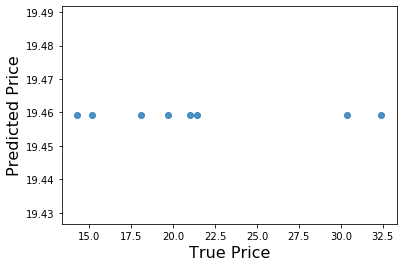

In [29]:
sns.regplot(x=y_test, y=pred_prices_base_test, fit_reg=False)
plt.xlabel("True Price", fontsize=16)
plt.ylabel("Predicted Price", fontsize=16)

#### My Predictive Model
To compare our null model, we can create a multiple regression model using the features I identified as predictive. For this, I will be using the top 7 features from my previous sorted list of predictions. 

1. Number of cylinders
2. Displacement
3. Weight
4. Engine shape
5. horsepower
6. Transmission
7. Number of carburetors

First we define our method for creating feature matrixes out of the desired predictive features we want to use. Then we will feed in our set containing only our 7 predictive features and generate a linear regression model.

In [30]:
def create_feature_matrices(df_train, df_test, selected_columns, dummy_columns=None):
    """
    Creates feature matrices for the training and testing sets from the given dataframes.
    The feature matrices are built from the columns given in selected columns.
    """
    
    if dummy_columns is None:
        dummy_columns = dict()
    
    # keep track of numerical features
    numerical_trial_columns = []
    
    # keep track of dummy features for categorical variables
    categorical_trial_columns = []
    
    # build feature lists
    for col_name in selected_columns:
        if col_name in dummy_columns:
            categorical_trial_columns.extend(dummy_columns[col_name])
        else:
            numerical_trial_columns.append(col_name)

    # transform numerical features
    if len(numerical_trial_columns) > 0:
        X_train_numerical = df_train[numerical_trial_columns].astype("float64").values
        X_test_numerical = df_test[numerical_trial_columns].astype("float64").values
    
        #imputer = Imputer(missing_values=0)
        #X_train_numerical = imputer.fit_transform(X_train_numerical)
        #X_test_numerical = imputer.transform(X_test_numerical)
    
        scaler = StandardScaler()
        X_train_numerical = scaler.fit_transform(X_train_numerical)
        X_test_numerical = scaler.transform(X_test_numerical)
    
    # select categorical features
    if len(categorical_trial_columns) > 0:
        X_train_categorical = df_train[categorical_trial_columns].astype("float64").values
        X_test_categorical = df_test[categorical_trial_columns].astype("float64").values
    
    # concatenate feature matrices
    if len(numerical_trial_columns) > 0 and len(categorical_trial_columns) > 0:
        X_train = np.hstack([X_train_numerical, X_train_categorical])
        X_test = np.hstack([X_test_numerical, X_test_categorical])
    elif len(numerical_trial_columns) > 0:
        X_train = X_train_numerical
        X_test = X_test_numerical
    else:
        X_train = X_train_categorical
        X_test = X_test_categorical
        
    return X_train, X_test

In [31]:
X_train, X_test = create_feature_matrices(df_train, df_test, predictive_all_columns, dummy_columns=dummy_columns)

print(y_train.shape, y_test.shape, X_train.shape, X_train.shape)

lr = SGDRegressor(max_iter=5000)
lr.fit(X_train, y_train)
pred_mpg_test = lr.predict(X_test)

mse = mean_squared_error(y_test, pred_mpg_test)
rmse = np.sqrt(mse)
print()
print("Model MSE:", mse)
print("Model RMSE:", rmse)

(24,) (8,) (24, 16) (24, 16)

Model MSE: 5.67182731300853
Model RMSE: 2.3815598487143945


As we can see, our model which used the features we identified as predictive has a much better RMSE then the null model. Let's plot our predictive model to see how much better it actually is.

Text(0, 0.5, 'Predicted mpg')

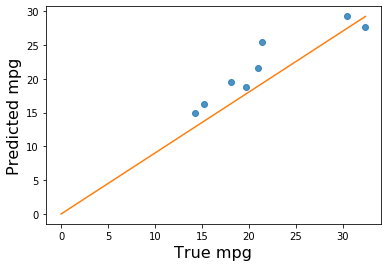

In [32]:
sns.regplot(x=y_test, y=pred_mpg_test, fit_reg=False)
plt.plot([0, np.max(y_test)], [0, np.max(pred_mpg_test)])
plt.xlabel("True mpg", fontsize=16)
plt.ylabel("Predicted mpg", fontsize=16)

This model is better than the null model for sure, but it still may not be the best possible model we can create. Let’s try and use a greedy algorithm to allow the computer to determine which variables have the most predictive power and build a model on those features.

#### Greedy Predictive Model
First, we define our method for sorting the predictive features as those which decrease the RMSE and sort the collumns on their RMSE.

In [33]:
def sort_columns(df_train, df_test, y_train, y_test, all_columns, dummy_columns=None):
    column_rmses = []

    for col_name in all_columns:
        X_train, X_test = create_feature_matrices(df_train,
                                                 df_test,
                                                 [col_name],
                                                 dummy_columns=dummy_columns)
    
        simple_lr = SGDRegressor(max_iter=5000)
        simple_lr.fit(X_train, y_train)
        pred_prices_simple_test = simple_lr.predict(X_test)
        simple_mse = mean_squared_error(y_test, pred_prices_simple_test)
        simple_rmse = np.sqrt(simple_mse)
        print()
        print(col_name + " Model MSE:", simple_mse)
        print(col_name + " Model RMSE:", simple_rmse)
        column_rmses.append((simple_rmse, col_name))
    
    column_rmses.sort(key=lambda p: p[0])
    sorted_columns = [col_name for _, col_name in column_rmses]
    print()
    print("Sorted columns:" + str(sorted_columns))
    
    return sorted_columns

In [37]:
df_train, df_test = train_test_split(cars_df)
sorted_columns = sort_columns(df_train, df_test, y_train, y_test, all_columns, dummy_columns=dummy_columns)


disp Model MSE: 40.903663657768504
disp Model RMSE: 6.395597208843636

wt Model MSE: 37.707457757355854
wt Model RMSE: 6.140639849181505

hp Model MSE: 41.16734360344991
hp Model RMSE: 6.416178270859524

cyl Model MSE: 39.196008658726555
cyl Model RMSE: 6.2606715820849885

vs Model MSE: 41.66991006040797
vs Model RMSE: 6.455223470989054

am Model MSE: 39.990579128729394
am Model RMSE: 6.323810491209346

carb Model MSE: 33.14745858818963
carb Model RMSE: 5.757382963481727

drat Model MSE: 42.447029454901795
drat Model RMSE: 6.515138483171467

qsec Model MSE: 44.48802326255499
qsec Model RMSE: 6.669934277229048

gear Model MSE: 41.99801540791908
gear Model RMSE: 6.48058758199587

Sorted columns:['carb', 'wt', 'cyl', 'am', 'disp', 'hp', 'vs', 'gear', 'drat', 'qsec']


Now that the features are sorted based on their predictive power, we can feed them into our greedy algorithm. This method will attempt to add features 1 at a time and discard those which do not decrease the RMSE.

In [36]:
def select_features(df_train, df_test, y_train, y_test, sorted_columns, dummy_columns=None):
    lr = SGDRegressor(max_iter=5000)
    
    train_zeros = np.zeros((y_train.shape[0], 1))
    test_zeros = np.zeros((y_test.shape[0], 1))
    lr.fit(train_zeros, y_train)
    pred_y_test = lr.predict(test_zeros)
    
    null_mse = mean_squared_error(y_test, pred_y_test)
    null_rmse = np.sqrt(null_mse)
    
    base_model_columns = []
    base_rmse = null_rmse
    base_mse = null_mse

    print("Base Model MSE:", base_mse)
    print("Base Model RMSE:", base_rmse)
    print()

    for col_name in sorted_columns:
        # track all column names
        trial_columns = base_model_columns[:]
        trial_columns.append(col_name)

        X_train, X_test = create_feature_matrices(df_train,
                                                  df_test,
                                                  trial_columns,
                                                  dummy_columns=dummy_columns)
    
        lr = SGDRegressor(max_iter=5000)
        lr.fit(X_train, y_train)
        pred_y_test = lr.predict(X_test)
        trial_mse = mean_squared_error(y_test, pred_y_test)
        trial_rmse = np.sqrt(trial_mse)
        print()
        print(str(trial_columns) + " Model MSE:", trial_mse)
        print(str(trial_columns) + " Model RMSE:", trial_rmse)
    
        if trial_rmse < base_rmse:
            print("Updating base model")
            base_rmse = trial_rmse
            base_mse = trial_mse
            base_model_columns = trial_columns
        
        print()
        print("Base Model MSE:", base_mse)
        print("Base Model RMSE:", base_rmse)
        print()
    
    print("Our chosen columns are: " + str(base_model_columns))
    return base_model_columns

In [38]:
selected_columns = select_features(df_train, df_test, y_train, y_test, sorted_columns, dummy_columns=dummy_columns)

Base Model MSE: 42.47052413165243
Base Model RMSE: 6.516941317186494


['carb'] Model MSE: 33.12525679117758
['carb'] Model RMSE: 5.755454525159379
Updating base model

Base Model MSE: 33.12525679117758
Base Model RMSE: 5.755454525159379


['carb', 'wt'] Model MSE: 32.30488392727206
['carb', 'wt'] Model RMSE: 5.683738551980735
Updating base model

Base Model MSE: 32.30488392727206
Base Model RMSE: 5.683738551980735


['carb', 'wt', 'cyl'] Model MSE: 24.113420973042544
['carb', 'wt', 'cyl'] Model RMSE: 4.910541820720249
Updating base model

Base Model MSE: 24.113420973042544
Base Model RMSE: 4.910541820720249


['carb', 'wt', 'cyl', 'am'] Model MSE: 23.092814817023935
['carb', 'wt', 'cyl', 'am'] Model RMSE: 4.805498394237993
Updating base model

Base Model MSE: 23.092814817023935
Base Model RMSE: 4.805498394237993


['carb', 'wt', 'cyl', 'am', 'disp'] Model MSE: 23.813691590934653
['carb', 'wt', 'cyl', 'am', 'disp'] Model RMSE: 4.87992741656417

Base Model MSE: 23.092814817023935
Base M

Our greedy algorithm selected features it believes is most predictive. What’s interesting is that the RMSE is actually worse than our hypothesized model. I’m not really sure as to why it didn’t pick up on the same features as I did but let’s plot the model and compare.

In [39]:
X_train, X_test = create_feature_matrices(df_train, df_test, selected_columns, dummy_columns=dummy_columns)

print(X_train.shape, X_test.shape)

lr = SGDRegressor(max_iter=5000)
lr.fit(X_train, y_train)
pred_prices_test = lr.predict(X_test)

mse = mean_squared_error(y_test, pred_prices_test)
rmse = np.sqrt(mse)
print()
print("Model MSE:", mse)
print("Model RMSE:", rmse)

(24, 15) (8, 15)

Model MSE: 22.633368097600133
Model RMSE: 4.757453951180204


Text(0, 0.5, 'Predicted mpg')

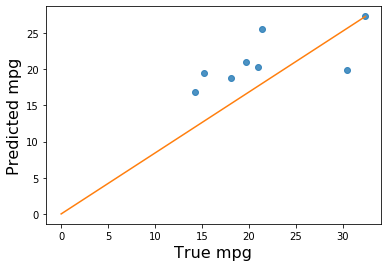

In [41]:
sns.regplot(x=y_test, y=pred_prices_test, fit_reg=False)
plt.plot([0, np.max(y_test)], [0, np.max(pred_prices_test)])
plt.xlabel("True mpg", fontsize=16)
plt.ylabel("Predicted mpg", fontsize=16)

Overall, the greedy model performed better than the null model but is worse than my predictive model. 

#### All Model
Finally, just to compare against, we can create an "all model" which uses all of the features as predictors to mpg.

In [42]:
X_train, X_test = create_feature_matrices(df_train, df_test, all_columns, dummy_columns=dummy_columns)

print(X_train.shape, X_test.shape)

lr = SGDRegressor(max_iter=5000)
lr.fit(X_train, y_train)
pred_prices_test = lr.predict(X_test)

mse = mean_squared_error(y_test, pred_prices_test)
rmse = np.sqrt(mse)
print()
print("Model MSE:", mse)
print("Model RMSE:", rmse)

(24, 21) (8, 21)

Model MSE: 30.447031805469006
Model RMSE: 5.51788290972806


Text(0, 0.5, 'Predicted mpg')

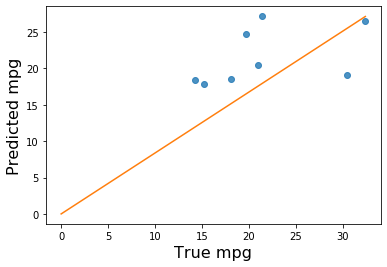

In [43]:
sns.regplot(x=y_test, y=pred_prices_test, fit_reg=False)
plt.plot([0, np.max(y_test)], [0, np.max(pred_prices_test)])
plt.xlabel("True mpg", fontsize=16)
plt.ylabel("Predicted mpg", fontsize=16)

 The all model turned out to be better than the null model but worse than the greedy algorithm and my predictive model. 

### Model evaluation and reflection
The null model had an RMSE of 6.52, my predictive model had an RMSE of 2.38, the greedy algorithm had an RMSE of 4.76, and finally the all model had an RMSE of 5.52.

It’s almost to be expected that the null model has the worst predictive power, with the all model being better but still not great. What’s most interesting is how the greedy algorithm was not as good as my predictive model. This likely is attributed to differences in the testing and training data sets (since they were so small). My predictive model was based on being able to see the entire population and guessed trends based on that; versus the greedy model which was limited to only the training data set and it is likely the case that the training data set was not a great representation of the testing set and by extension the entire population. Therefore, the greedy algorithm made predictions that it thought was most effective based on the training data set. But in reality, the training data set was likley quite different then the testing set.

In the end, I think the most predictive features were those which were in my model but not in the greedy model. This includes displacement and horsepower because these were the features that must have made my model that much more predictive then the greedy model (since my model was the most accurate). Next up in line could be features that both my model and the greedy model shared such as number of carburetors, number of cylinders, transmission type, and engine shape. The rest of the features predictive capabilities are much more questionable.